In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import os

# Définir le chemin du dossier
base_path = "/content/drive/My Drive/dataextractionfinal"

# Vérifier que les fichiers existent avant de les lire
train_path = os.path.join(base_path, "train.csv")
val_path = os.path.join(base_path, "validation.csv")
test_path = os.path.join(base_path, "test.csv")

for path in [train_path, val_path, test_path]:
    if not os.path.exists(path):
        print(f"Fichier introuvable : {path}")

# Charger les fichiers CSV s'ils existent
if all(os.path.exists(p) for p in [train_path, val_path, test_path]):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    # Vérifier le chargement des données
    print(train_df.head())
else:
    print("Un ou plusieurs fichiers manquent. Vérifiez le chemin.")


     Column1;Column2;Column3;Column4;Column5;Column6
0  image_name;BoxesString;domain;country ;locatio...
1  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...
2  a2a15938845d9812de03bd44799c4b1bf856a8ad11752e...
3  401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cd...
4  0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8...


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Définir la taille des images
image_size = (224, 224)

# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["developement_stage"])
val_df["label"] = label_encoder.transform(val_df["developement_stage"])
test_df["label"] = label_encoder.transform(test_df["developement_stage"])

# Fonction pour charger une image depuis Google Drive
def load_image(image_name):
    image_path = os.path.join(base_path, "images", image_name)
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img) / 255.0  # Normalisation
    return img

# Charger toutes les images
train_images = [load_image(img) for img in train_df["image_name"]]
val_images = [load_image(img) for img in val_df["image_name"]]
test_images = [load_image(img) for img in test_df["image_name"]]

# Convertir en tensors
import tensorflow as tf

train_images_tensor = tf.convert_to_tensor(train_images)
train_labels_tensor = tf.convert_to_tensor(train_df["label"].values)

val_images_tensor = tf.convert_to_tensor(val_images)
val_labels_tensor = tf.convert_to_tensor(val_df["label"].values)


KeyError: 'developement_stage'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Définir les chemins vers les fichiers CSV
train_csv_path = "/content/drive/MyDrive/dataextractionfinal/train.csv"
val_csv_path = "/content/drive/MyDrive/dataextractionfinal/validation.csv"
test_csv_path = "/content/drive/MyDrive/dataextractionfinal/test.csv"

# Charger les CSV
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Vérifier les premières lignes des datasets
print(train_df.head())

# Assurez-vous que les CSV contiennent une colonne "image_path" et "label"
# Convertir les chemins des images pour correspondre à Google Drive
base_image_path = "/content/drive/MyDrive/dataextractionfinal/images/"

train_df["image_name"] = train_df["image_name"].apply(lambda x: os.path.join(base_image_path, x))
val_df["image_name"] = val_df["image_name"].apply(lambda x: os.path.join(base_image_path, x))
test_df["image_name"] = test_df["image_name"].apply(lambda x: os.path.join(base_image_path, x))

# Vérifier le nombre de classes
num_classes = train_df["developement_stage"].nunique()
print(f"Nombre de classes : {num_classes}")

# Paramètres
img_size = (128, 128)
batch_size = 32

# Générateurs d'images avec augmentation des données
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.0)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col="image_name",
    y_col="developement_stage",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col="image_name",
    y_col="developement_stage",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Définition du modèle CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

# Entraînement du modèle
epochs = 10
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)

# Sauvegarde du modèle
model.save("/content/drive/MyDrive/dataextractionfinal/wheat_growth_model.h5")

# Évaluation sur le jeu de test
test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col="image_path",
    y_col="developement_stage",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     Column1;Column2;Column3;Column4;Column5;Column6
0  image_name;BoxesString;domain;country ;locatio...
1  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...
2  a2a15938845d9812de03bd44799c4b1bf856a8ad11752e...
3  401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cd...
4  0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8...


KeyError: 'image_name'

In [ ]:
# Installer les bibliothèques nécessaires
!pip install tensorflow pandas pillow scikit-learn


In [ ]:
import os
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV avec le bon séparateur (;) et ignorer la première ligne
csv_file = "/content/drive/MyDrive/dataextractionfinal/train.csv"  # Remplacez par le chemin de votre fichier CSV
df = pd.read_csv(csv_file, sep=';', header=None)

# Afficher les premières lignes pour comprendre la structure des données
df.columns = ['image_name', 'BoxesString', 'domain', 'country', 'location', 'developement_stage']
df = df.drop(0).reset_index(drop=True)

# Fonction pour nettoyer les noms d'images (éliminer les espaces ou caractères indésirables)
def clean_image_name(image_name):
    return image_name.strip().lower()  # Enlever les espaces et passer en minuscule

# Fonction pour charger une image
def load_image(image_name, image_dir):
    image_name = clean_image_name(image_name)  # Nettoyer le nom de l'image
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path):  # Vérifier si l'image existe
        return Image.open(image_path)
    else:
        print(f"Image {image_name} non trouvée dans le dossier {image_dir}")
        return None

# Prétraiter les images : redimensionnement et normalisation
def preprocess_image(image, target_size=(224, 224)):
    image = image.resize(target_size)  # Redimensionner l'image
    image = np.array(image) / 255.0  # Normalisation
    return image

# Encoder les labels 'development_stage'
label_encoder = LabelEncoder()
df['development_stage_encoded'] = label_encoder.fit_transform(df['developement_stage'])

# Préparer les images et les étiquettes pour l'entraînement
def prepare_data(df, image_dir):
    images = []
    labels = []
    missing_images = []  # Liste des images manquantes
    for _, row in df.iterrows():
        image = load_image(row['image_name'], image_dir)
        if image is not None:  # Si l'image a été chargée avec succès
            image = preprocess_image(image)
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        else:
            missing_images.append(row['image_name'])
    return np.array(images), np.array(labels), missing_images

# Dossier des images
image_dir = '/content/drive/MyDrive/dataextractionfinal/images/'  # Remplacez par le chemin vers votre dossier d'images

# Charger les images et les labels
images, labels, missing_images = prepare_data(df, image_dir)

# Afficher les images manquantes
if missing_images:
    print(f"Les images suivantes sont manquantes : {missing_images}")
else:
    print("Toutes les images ont été chargées avec succès.")

# Charger le modèle pré-entraîné ResNet50 et ajouter des couches personnalisées
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Créer le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Congeler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model.fit(images, labels, epochs=10, batch_size=32, validation_split=0.2)

# Fonction de prédiction pour une nouvelle image
def predict_image(image, model, label_encoder):
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_class

# Exemple de prédiction pour une image spécifique
image_name = 'image_example.jpg'  # Remplacez par le nom de votre image
image = load_image(image_name, image_dir)
if image:
    predicted_stage = predict_image(image, model, label_encoder)
    print(f"Le développement de la plante est : {predicted_stage[0]}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image image_name non trouvée dans le dossier /content/drive/MyDrive/dataextractionfinal/images/
Image 4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e36f7c6aaf097c7ce423.png non trouvée dans le dossier /content/drive/MyDrive/dataextractionfinal/images/
Image a2a15938845d9812de03bd44799c4b1bf856a8ad11752e81c94dc8d138515021.png non trouvée dans le dossier /content/drive/MyDrive/dataextractionfinal/images/
Image 401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cdd7d1ce8a0f19be7d2b.png non trouvée dans le dossier /content/drive/MyDrive/dataextractionfinal/images/
Image be1652110a44acd24b42784356e965ce84a04893c3f1bb3958b09fc7bc4eda2e.png non trouvée dans le dossier /content/drive/MyDrive/dataextractionfinal/images/
Image b3884abdad8e98013cb50b37733929975b55d84c44cfa7b097e3b88384eaf78a.png non trouvée dans le dossier /content/drive/MyDrive/dataextractionfinal/images/
Image

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train.csv"
df = pd.read_csv(csv_file, sep=';', header=None)

# Définir les colonnes
df.columns = ['image_name', 'BoxesString', 'domain', 'country', 'location', 'developement_stage']
df = df.drop(0).reset_index(drop=True)

# Nettoyer les noms d'images
def clean_image_name(image_name):
    return image_name.strip().lower()

# Vérifier la présence des images et filtrer
image_dir = '/content/drive/MyDrive/dataextractionfinal/images/'
existing_images = set(os.listdir(image_dir))

df['image_name'] = df['image_name'].apply(clean_image_name)
df = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

print(f"Nombre d'images après suppression des manquantes : {len(df)}")

# Sauvegarder le CSV mis à jour
filtered_csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df.to_csv(filtered_csv_file, sep=';', index=False)
print(f"Fichier mis à jour enregistré sous : {filtered_csv_file}")


Mounted at /content/drive
Nombre d'images après suppression des manquantes : 804
Fichier mis à jour enregistré sous : /content/drive/MyDrive/dataextractionfinal/train_filtered.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset filtré enregistré : /content/drive/MyDrive/dataextractionfinal/train_final.csv


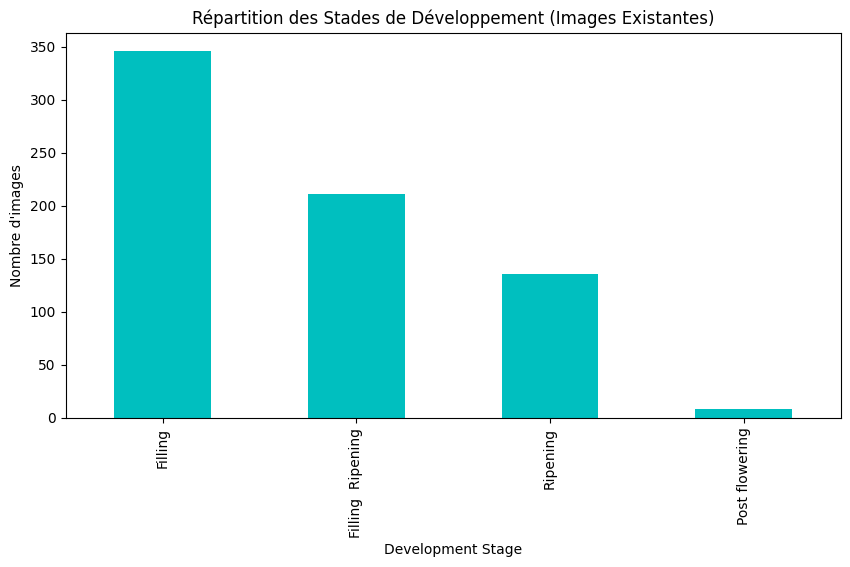

🚦 Distribution des classes avant équilibrage: development_stage_encoded
0    346
1    211
3    136
4    103
2      8
Name: count, dtype: int64
🚦 Distribution des classes après équilibrage: development_stage_encoded
3    346
2    346
4    346
0    346
1    346
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 418s 9s/step - accuracy: 0.2706 - loss: 1.8041 - val_accuracy: 0.1705 - val_loss: 4.8983
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 402s 9s/step - accuracy: 0.4852 - loss: 1.2878 - val_accuracy: 0.1705 - val_loss: 4.5359
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 447s 9s/step - accuracy: 0.5789 - loss: 1.0457 - val_accuracy: 0.2399 - val_loss: 2.1381
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 411s 9s/step - accuracy: 0.6080 - loss: 0.9605 - val_accuracy: 0.3555 - val_loss: 2.2624
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 404s 9s/step - accuracy: 0.6655 - loss: 0.8535 - val_accuracy: 0.3526 - val_loss: 2.9430
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 442s 9s/step - accuracy: 0.6512 - loss: 0.8379 - val_accuracy: 0.3353 - val_loss: 3.0073
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 412s 9s/step - accuracy: 0.7047 - loss: 0.8011 - val_accuracy: 0.3613 - val_loss: 3.7687
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 406s 9s/step - accuracy: 0.6701 - loss: 0.7583 - val_accuracy: 0.3699 - v

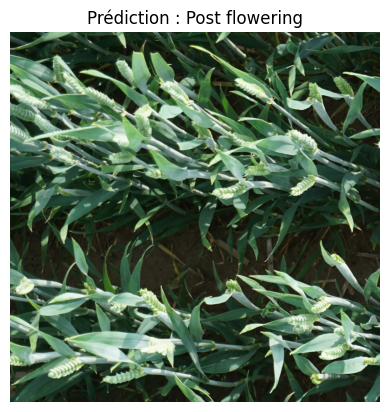

'Post flowering'

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
from google.colab import drive

# 🚀 Monter Google Drive
drive.mount('/content/drive')

# 📂 Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# 📂 Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# 📝 Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)
print(f"✅ Dataset filtré enregistré : {final_csv_path}")

# 📊 Afficher la distribution des classes
plt.figure(figsize=(10, 5))
df_existing['developement_stage'].value_counts().plot(kind='bar', color='c')
plt.xlabel("Development Stage")
plt.ylabel("Nombre d'images")
plt.title("Répartition des Stades de Développement (Images Existantes)")
plt.show()

# 🔠 Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# ✅ Équilibrer les classes
class_counts = df_existing['development_stage_encoded'].value_counts()
print("🚦 Distribution des classes avant équilibrage:", class_counts)

# Trouver la classe majoritaire
max_count = class_counts.max()

# Sur-échantillonner les classes minoritaires
df_balanced = df_existing.copy()
for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True)], axis=0)

df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
print("🚦 Distribution des classes après équilibrage:", df_balanced['development_stage_encoded'].value_counts())

# 📥 Charger les images et labels après équilibrage
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0  # Normalisation
            image = np.nan_to_num(image)  # Remplacement des NaN
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# 📌 Vérifier s'il y a des `nan` dans les données
if np.isnan(images).any():
    print("❌ Problème : Des `nan` existent dans les images après prétraitement !")

# 📦 Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% pour validation
)

# 📦 ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 🔗 Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)  # Ajout d'un Dropout pour éviter l'overfitting
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# 📌 Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# ❄️ Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# 🎯 Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ⏳ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 🚀 Entraînement
train_generator = datagen.flow(images, labels, batch_size=32, subset='training')
val_generator = datagen.flow(images, labels, batch_size=32, subset='validation')

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# 📌 Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None

    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

    # 🔍 Vérification
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()

    return predicted_class[0]

# 🔍 Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"  # Remplace par une image existante
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive

# 🎯 Monter Google Drive
drive.mount('/content/drive')

# 📂 Charger le fichier CSV filtré
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df = pd.read_csv(csv_file, sep=';')

# 📂 Dossier contenant les images
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"

# 🔠 Encoder les labels 'development_stage'
label_encoder = LabelEncoder()
df['development_stage_encoded'] = label_encoder.fit_transform(df['developement_stage'])

# 📌 Charger uniquement les images existantes
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        if os.path.exists(image_path):  # Vérifier si l'image existe
            image = Image.open(image_path).resize(target_size)
            image = np.array(image) / 255.0  # Normalisation
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
    return np.array(images), np.array(labels)

# 📥 Charger les images et labels après filtrage
images, labels = load_and_preprocess_images(df, image_dir)

# 🔀 Mélanger avant la séparation
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# 🏗️ Création des générateurs de données avec Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

batch_size = 32  # 🔀 Augmenté pour plus de stabilité

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

# 📦 Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# ❄️ Débloquer certaines couches du modèle pour Fine-tuning
for layer in base_model.layers[-30:]:  # Débloquer les 30 dernières couches
    layer.trainable = True

# 🔗 Ajouter des couches personnalisées avec Dropout optimisé
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)  # 🔽 Réduction pour garder plus d'info
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)  # 🔽 Moins de dropout
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# 📌 Construire le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# 🎯 Compiler le modèle avec un Learning Rate Scheduler
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 📌 Callbacks améliorés
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# 🚀 Entraînement avec régularisation et Early Stopping amélioré
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# 📌 Fonction de prédiction sur une image
def predict_image(image, model, label_encoder):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_class[0]

# 🔍 Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"  # Remplace par une image existante
image_path = os.path.join(image_dir, image_name)
if os.path.exists(image_path):
    image = Image.open(image_path)
    predicted_stage = predict_image(image, model, label_encoder)
    print(f"🌱 Le développement de la plante est : {predicted_stage}")
else:
    print("⚠️ L'image demandée n'existe pas !")


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 565s 25s/step - accuracy: 0.4458 - loss: 1.3041 - val_accuracy: 0.1677 - val_loss: 1.5502 - learning_rate: 1.0000e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 515s 24s/step - accuracy: 0.8013 - loss: 0.5311 - val_accuracy: 0.1677 - val_loss: 1.5467 - learning_rate: 1.0000e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 513s 24s/step - accuracy: 0.8822 - loss: 0.3223 - val_accuracy: 0.3106 - val_loss: 1.4217 - learning_rate: 1.0000e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 517s 25s/step - accuracy: 0.9066 - loss: 0.2382 - val_accuracy: 0.4286 - val_loss: 2.4526 - learning_rate: 1.0000e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 513s 24s/step - accuracy: 0.9735 - loss: 0.1142 - val_accuracy: 0.1677 - val_loss: 2.3791 - learning_rate: 1.0000e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 512s 24s/step - accuracy: 0.9642 - loss: 0.1167 - val_accuracy: 0.1677 - val_loss: 6.6635 - learning_rate: 1.0000e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 512s 24s/step - accuracy: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset filtré enregistré : /content/drive/MyDrive/dataextractionfinal/train_final.csv


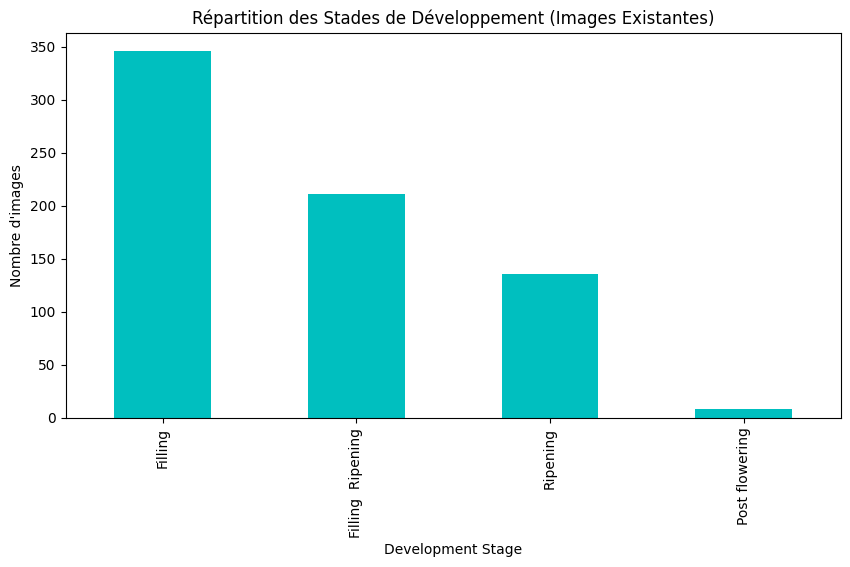

                                         BoxesString  \
0  112 274 188 303;892 812 958 847;0 889 67 928;1...   
1  982 627 1024 685;257 499 317 590;604 500 665 5...   
2  922 135 1024 217;141 510 182 571;709 660 751 7...   
3  418 98 473 178;109 230 165 263;0 807 50 864;0 ...   
4  30 1 83 42;152 158 195 188;565 190 607 228;378...   

                                        box_features  
0  [[112, 274, 188, 303], [892, 812, 958, 847], [...  
1  [[982, 627, 1024, 685], [257, 499, 317, 590], ...  
2  [[922, 135, 1024, 217], [141, 510, 182, 571], ...  
3  [[418, 98, 473, 178], [109, 230, 165, 263], [0...  
4  [[30, 1, 83, 42], [152, 158, 195, 188], [565, ...  


<ipython-input-4-e02a0314d717>:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'box_{i}_x_min', f'box_{i}_y_min', f'box_{i}_x_max', f'box_{i}_y_max']] = pd.DataFrame(
<ipython-input-4-e02a0314d717>:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'box_{i}_x_min', f'box_{i}_y_min', f'box_{i}_x_max', f'box_{i}_y_max']] = pd.DataFrame(
<ipython-input-4-e02a0314d717>:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 400s 9s/step - accuracy: 0.2822 - loss: 1.7875 - val_accuracy: 0.2081 - val_loss: 2.1333 - learning_rate: 5.0000e-04
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 400s 9s/step - accuracy: 0.4479 - loss: 1.3000 - val_accuracy: 0.4162 - val_loss: 1.3429 - learning_rate: 5.0000e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 389s 9s/step - accuracy: 0.4960 - loss: 1.1964 - val_accuracy: 0.4566 - val_loss: 1.2208 - learning_rate: 5.0000e-04
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 391s 9s/step - accuracy: 0.5594 - loss: 1.0738 - val_accuracy: 0.4393 - val_loss: 1.3374 - learning_rate: 5.0000e-04
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 380s 9s/step - accuracy: 0.6099 - loss: 1.0079 - val_accuracy: 0.3988 - val_loss: 1.6938 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 392s 9s/step - accuracy: 0.5656 - loss: 1.0413 - val_accuracy: 0.5607 - val_loss: 1.0809 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 425s 9s/step - accuracy: 0.6249 

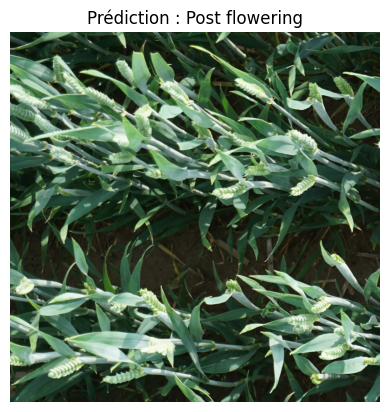

'Post flowering'

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)
print(f"✅ Dataset filtré enregistré : {final_csv_path}")

# Afficher la distribution des classes
plt.figure(figsize=(10, 5))
df_existing['developement_stage'].value_counts().plot(kind='bar', color='c')
plt.xlabel("Development Stage")
plt.ylabel("Nombre d'images")
plt.title("Répartition des Stades de Développement (Images Existantes)")
plt.show()

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boxes depuis la colonne BoxesString
def extract_box_features(boxes_string):
    box_features = []
    if boxes_string == 'no_box':  # Vérifier si la valeur est 'no_box'
        return box_features  # Retourner une liste vide pour les cases sans boîte
    boxes = boxes_string.split(';')
    for box in boxes:
        try:
            coords = list(map(int, box.split()))
            # Assumer que les coordonnées sont en [x_min, y_min, x_max, y_max]
            if len(coords) == 4:
                box_features.append(coords)
        except ValueError:
            continue  # Ignorer les cases qui ne peuvent pas être converties en entiers
    return box_features

# Appliquer l'extraction des caractéristiques sur la colonne `BoxesString`
df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Afficher les premières lignes pour vérifier
print(df_existing[['BoxesString', 'box_features']].head())

# Créer une fonction pour créer des colonnes dynamiques pour les boîtes
def create_box_columns(df):
    # Calculer le nombre maximal de boîtes
    max_boxes = df['box_features'].apply(len).max()
    # Générer les colonnes pour chaque boîte
    for i in range(max_boxes):
        df[[f'box_{i}_x_min', f'box_{i}_y_min', f'box_{i}_x_max', f'box_{i}_y_max']] = pd.DataFrame(
            df['box_features'].apply(lambda boxes: boxes[i] if i < len(boxes) else [None, None, None, None]).tolist(),
            index=df.index
        )
    return df

# Appliquer la fonction pour créer les colonnes des boîtes
df_existing = create_box_columns(df_existing)

# Équilibrer les classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()
for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True)], axis=0)
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = True
#for layer in base_model.layers[-10:]:
 #   layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement
train_generator = datagen.flow(images, labels, batch_size=32, subset='training')
val_generator = datagen.flow(images, labels, batch_size=32, subset='validation')

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)


Mounted at /content/drive
✅ Dataset filtré enregistré : /content/drive/MyDrive/dataextractionfinal/train_final.csv


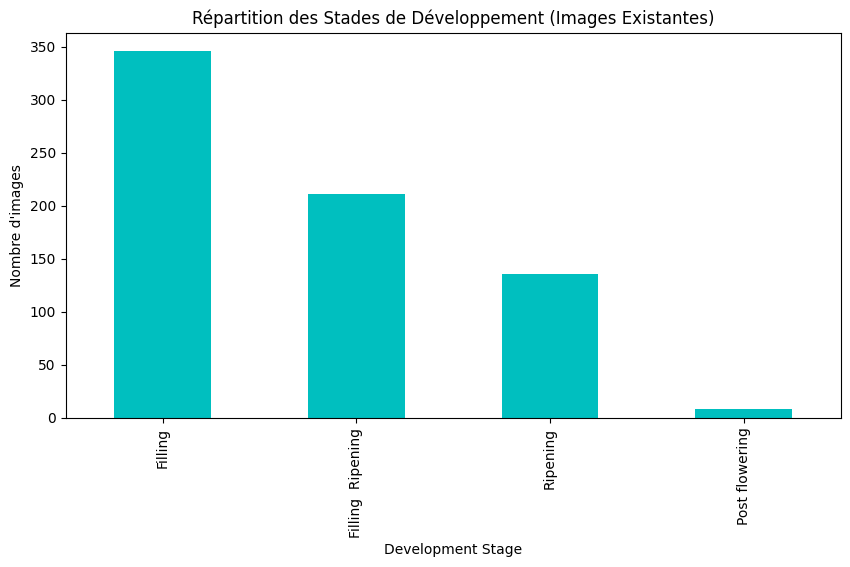

🚦 Distribution des classes avant équilibrage: development_stage_encoded
0    346
1    211
3    136
4    103
2      8
Name: count, dtype: int64
🚦 Distribution des classes après équilibrage: development_stage_encoded
3    346
2    346
4    346
0    346
1    346
Name: count, dtype: int64
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 972ms/step - accuracy: 0.1850 - loss: 1.7007 - val_accuracy: 0.1676 - val_loss: 1.6109
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 512ms/step - accuracy: 0.2091 - loss: 1.6093 - val_accuracy: 0.1676 - val_loss: 1.6114
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 533ms/step - accuracy: 0.2092 - loss: 1.6096 - val_accuracy: 0.1676 - val_loss: 1.6116
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 536ms/step - accuracy: 0.2262 - loss: 1.6084 - val_accuracy: 0.1676 - val_loss: 1.6123
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 534ms/step - accuracy: 0.1986 - loss: 1.6097 - val_accuracy: 0.1676 - val_loss: 1.6120
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 507ms/step - accuracy: 0.2052 - loss: 1.6097 - val_accuracy: 0.1676 - val_loss: 1.6120
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 534ms/step - accuracy: 0.2090 - loss: 1.6093 - val_accuracy: 0.1676 - val_loss: 1.6122
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 529ms/step - accuracy: 0.1939 - loss: 1.6103 - val_accu

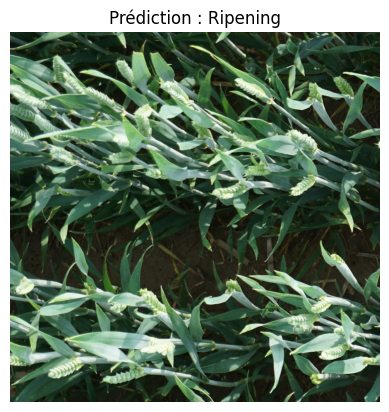

'Ripening'

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

# 🚀 Monter Google Drive
drive.mount('/content/drive')

# 📂 Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# 📂 Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# 📝 Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)
print(f"✅ Dataset filtré enregistré : {final_csv_path}")

# 📊 Afficher la distribution des classes
plt.figure(figsize=(10, 5))
df_existing['developement_stage'].value_counts().plot(kind='bar', color='c')
plt.xlabel("Development Stage")
plt.ylabel("Nombre d'images")
plt.title("Répartition des Stades de Développement (Images Existantes)")
plt.show()

# 🔠 Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# ✅ Équilibrer les classes
class_counts = df_existing['development_stage_encoded'].value_counts()
print("🚦 Distribution des classes avant équilibrage:", class_counts)

# Trouver la classe majoritaire
max_count = class_counts.max()

# Sur-échantillonner les classes minoritaires
df_balanced = df_existing.copy()
for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True)], axis=0)

df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
print("🚦 Distribution des classes après équilibrage:", df_balanced['development_stage_encoded'].value_counts())

# 📥 Charger les images et labels après équilibrage
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0  # Normalisation
            image = np.nan_to_num(image)  # Remplacement des NaN
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# 📌 Vérifier s'il y a des `nan` dans les données
if np.isnan(images).any():
    print("❌ Problème : Des `nan` existent dans les images après prétraitement !")

# 📦 Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% pour validation
)

# 📦 VGG16 pré-entraîné
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 🔗 Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)  # Ajout d'un Dropout pour éviter l'overfitting
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# 📌 Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# ❄️ Débloquer les 10 dernières couches de VGG16
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# 🎯 Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# 🚀 Entraînement
train_generator = datagen.flow(images, labels, batch_size=32, subset='training')
val_generator = datagen.flow(images, labels, batch_size=32, subset='validation')

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
)

# 📌 Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None

    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

    # 🔍 Vérification
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()

    return predicted_class[0]

# 🔍 Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"  # Remplace par une image existante
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 778ms/step - accuracy: 0.2530 - loss: 1.7615 - val_accuracy: 0.1908 - val_loss: 2.9640 - learning_rate: 5.0000e-04
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - accuracy: 0.4826 - loss: 1.2570 - val_accuracy: 0.3555 - val_loss: 1.9207 - learning_rate: 5.0000e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 439ms/step - accuracy: 0.5432 - loss: 1.1005 - val_accuracy: 0.3757 - val_loss: 1.6144 - learning_rate: 5.0000e-04
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 467ms/step - accuracy: 0.5770 - loss: 1.0583 - val_accuracy: 0.3815 - val_loss: 1.4538 - learning_rate: 5.0000e-04
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 440ms/step - accuracy: 0.5807 - loss: 1.0328 - val_accuracy: 0.5260 - val_loss: 1.2929 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - accuracy: 0.6331 - loss: 0.9275 - val_accuracy: 0.5260 - val_loss: 1.0830 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 439ms/step - acc

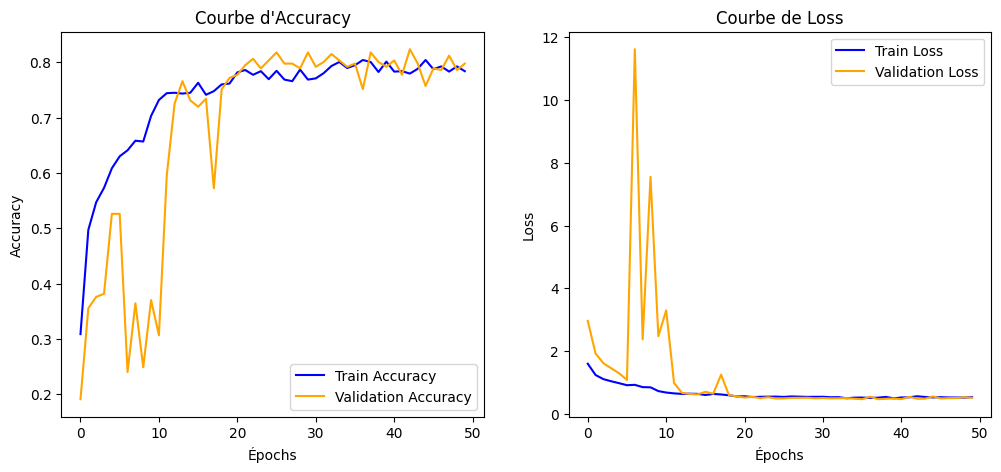

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


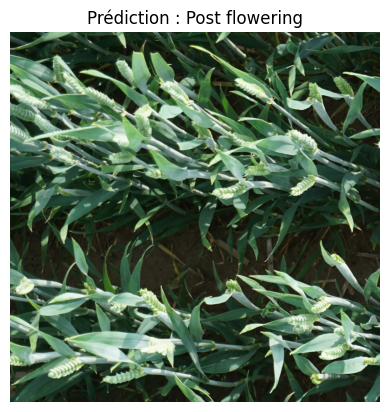

'Post flowering'

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=32, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 730ms/step - accuracy: 0.2776 - loss: 1.7502 - val_accuracy: 0.1705 - val_loss: 3.2151 - learning_rate: 5.0000e-04
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 501ms/step - accuracy: 0.5447 - loss: 1.1207 - val_accuracy: 0.3786 - val_loss: 2.3040 - learning_rate: 5.0000e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 525ms/step - accuracy: 0.5962 - loss: 1.0255 - val_accuracy: 0.2399 - val_loss: 7.2245 - learning_rate: 5.0000e-04
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 483ms/step - accuracy: 0.6036 - loss: 0.9853 - val_accuracy: 0.2428 - val_loss: 6.7699 - learning_rate: 5.0000e-04
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 442ms/step - accuracy: 0.6141 - loss: 0.9442 - val_accuracy: 0.2052 - val_loss: 4.8692 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 474ms/step - accuracy: 0.6793 - loss: 0.8380 - val_accuracy: 0.4277 - val_loss: 1.6912 - learning_rate: 1.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 443ms/step - acc

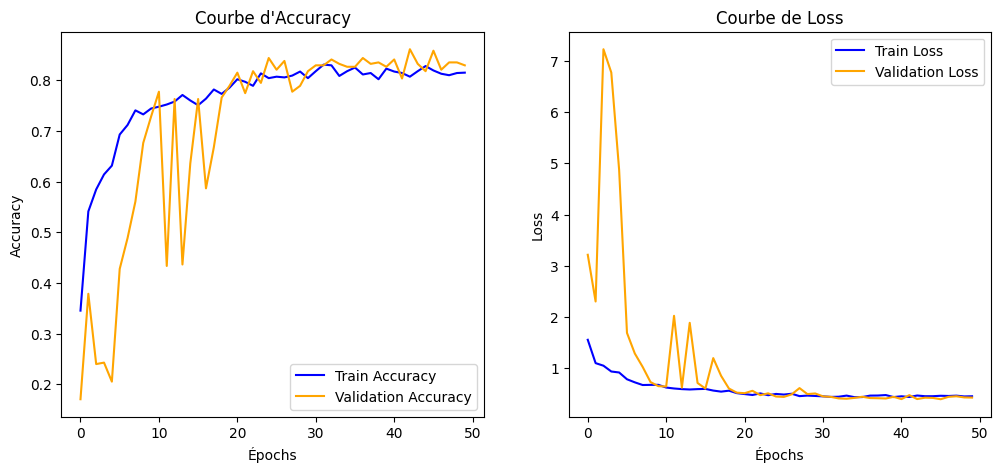

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


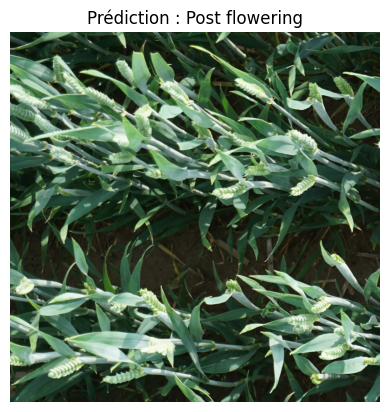

'Post flowering'

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 695ms/step - accuracy: 0.2736 - loss: 1.7498 - val_accuracy: 0.1705 - val_loss: 3.5889 - learning_rate: 5.0000e-04
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.5447 - loss: 1.1169 - val_accuracy: 0.2601 - val_loss: 3.4398 - learning_rate: 5.0000e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.6167 - loss: 1.0078 - val_accuracy: 0.2861 - val_loss: 2.3286 - learning_rate: 5.0000e-04
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 472ms/step - accuracy: 0.5974 - loss: 0.9704 - val_accuracy: 0.3295 - val_loss: 4.3285 - learning_rate: 5.0000e-04
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 440ms/step - accuracy: 0.6166 - loss: 0.9255 - val_accuracy: 0.4827 - val_loss: 1.3598 - learning_rate: 5.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 473ms/step - accuracy: 0.6411 - loss: 0.8627 - val_accuracy: 0.3873 - val_loss: 4.5346 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 463ms/step - acc

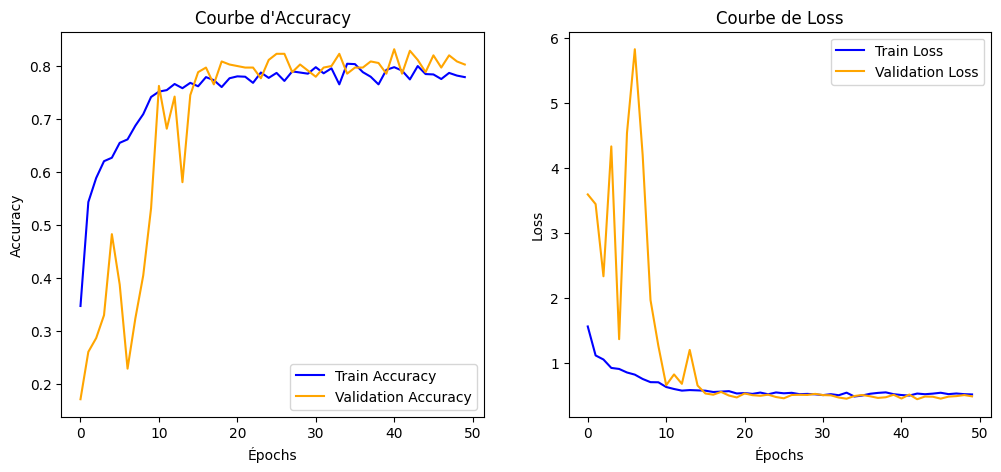

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


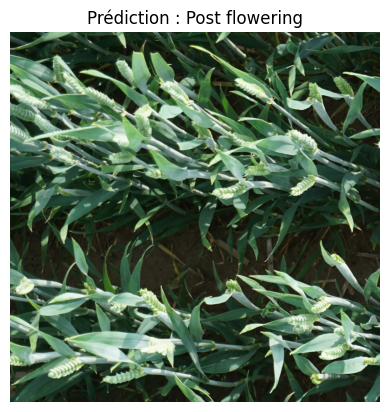

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
#Utilisation de ReduceLROnPlateau pour réduire le taux d'apprentissage si la perte de validation ne s'améliore pas pendant plusieurs époques.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)
model.save("/content/drive/MyDrive/dataextractionfinal/model_resnet50.h5")


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 297s 8s/step - accuracy: 0.4055 - loss: 1.4365 - val_accuracy: 0.2754 - val_loss: 2.7586 - learning_rate: 5.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 278s 8s/step - accuracy: 0.4647 - loss: 1.1394 - val_accuracy: 0.4565 - val_loss: 1.5837 - learning_rate: 5.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 359s 9s/step - accuracy: 0.5464 - loss: 1.0356 - val_accuracy: 0.5362 - val_loss: 1.0552 - learning_rate: 5.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.5773 - loss: 0.9466 - val_accuracy: 0.4529 - val_loss: 1.9714 - learning_rate: 5.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.5935 - loss: 0.8770 - val_accuracy: 0.5000 - val_loss: 1.7544 - learning_rate: 5.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 276s 8s/step - accuracy: 0.5939 - loss: 0.9200 - val_accuracy: 0.4891 - val_loss: 1.9167 - learning_rate: 5.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 326s 8s/step - accuracy: 0.6476 

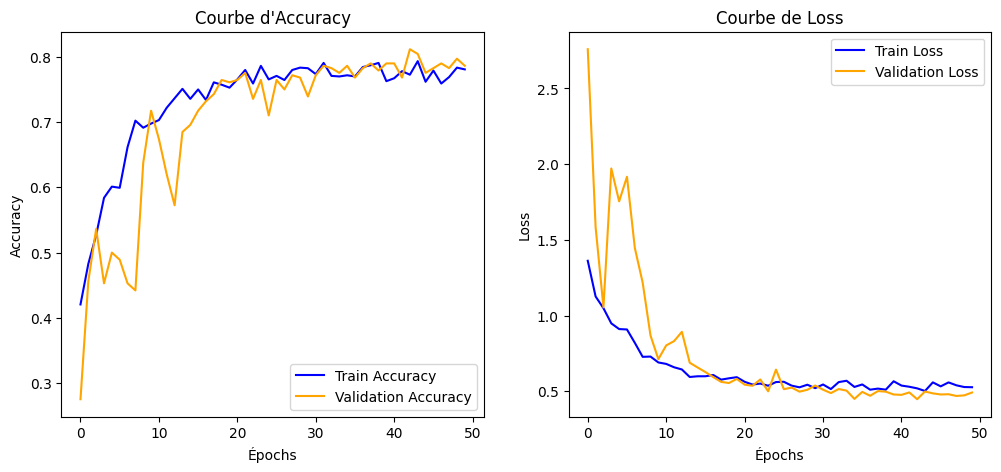

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


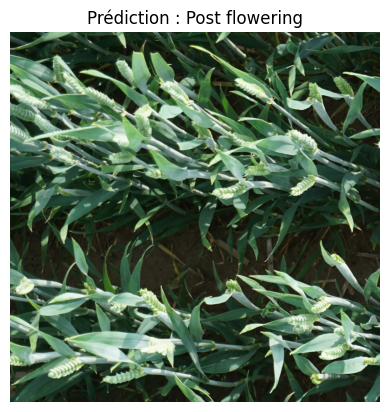

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Supprimer les lignes où le label est vide
df = df[df['developement_stage'].notna()]

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)

model.save("/content/drive/MyDrive/dataextractionfinal/model_resnet50.h5")


In [ ]:
import pickle

# Sauvegarder le LabelEncoder
with open("/content/drive/MyDrive/dataextractionfinal/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ LabelEncoder sauvegardé avec succès !")


✅ LabelEncoder sauvegardé avec succès !


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 40,394,126 (154.09 MB)

 Trainable params: 7,090,692 (27.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 14,181,386 (54.10 MB)

In [ ]:
print(label_encoder.classes_)

['Filling' 'Filling  Ripening' 'Post flowering' 'Ripening']


In [ ]:
print("Classes chargées:", label_encoder.classes_)


Classes chargées: ['Filling' 'Filling  Ripening' 'Post flowering' 'Ripening']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 767ms/step - accuracy: 0.3775 - loss: 1.4129 - val_accuracy: 0.5688 - val_loss: 1.1072 - learning_rate: 4.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.4762 - loss: 1.0660 - val_accuracy: 0.5036 - val_loss: 1.1708 - learning_rate: 4.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 448ms/step - accuracy: 0.6082 - loss: 0.8302 - val_accuracy: 0.4928 - val_loss: 1.2525 - learning_rate: 4.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 447ms/step - accuracy: 0.6790 - loss: 0.7387 - val_accuracy: 0.4094 - val_loss: 1.2433 - learning_rate: 4.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 446ms/step - accuracy: 0.7232 - loss: 0.6404 - val_accuracy: 0.7065 - val_loss: 0.7654 - learning_rate: 8.0000e-05
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 448ms/step - accuracy: 0.7297 - loss: 0.6004 - val_accuracy: 0.5036 - val_loss: 0.9225 - learning_rate: 8.0000e-05
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 483ms/step - acc

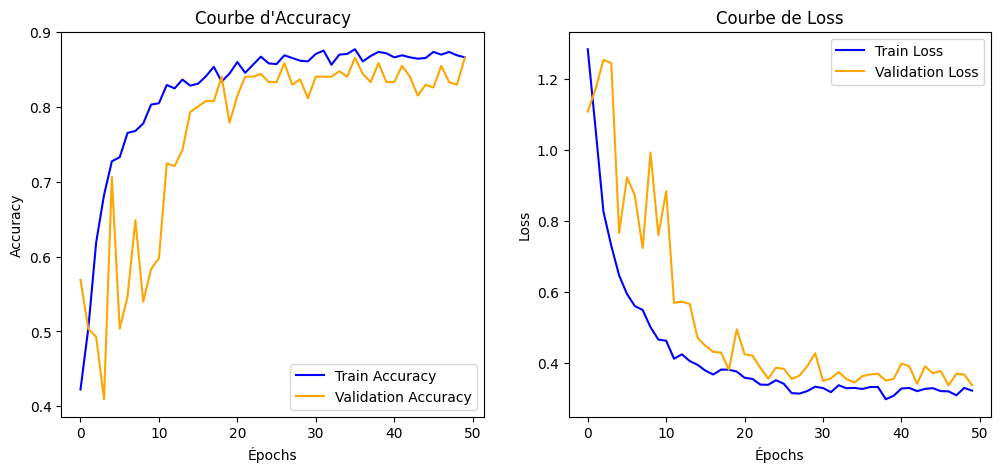

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


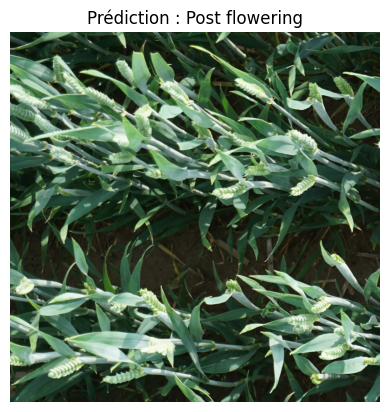

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Supprimer les lignes où le label est vide
df = df[df['developement_stage'].notna()]

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0004), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)

model.save("/content/drive/MyDrive/dataextractionfinal/model_resnet50.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 512ms/step - accuracy: 0.4151 - loss: 1.3878 - val_accuracy: 0.2754 - val_loss: 6.1948 - learning_rate: 4.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.7000 - loss: 0.7041 - val_accuracy: 0.6993 - val_loss: 0.7736 - learning_rate: 4.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7504 - loss: 0.6140 - val_accuracy: 0.4457 - val_loss: 1.4549 - learning_rate: 4.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7602 - loss: 0.5379 - val_accuracy: 0.3043 - val_loss: 5.0219 - learning_rate: 4.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.7890 - loss: 0.4766 - val_accuracy: 0.5942 - val_loss: 1.8729 - learning_rate: 4.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8600 - loss: 0.3283 - val_accuracy: 0.2717 - val_loss: 2.4380 - learning_rate: 8.0000e-05
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.8759 - 

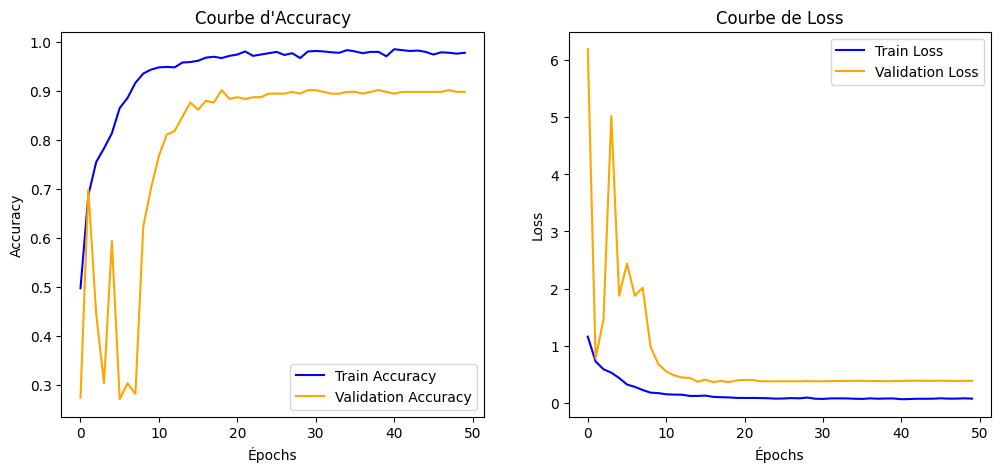

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


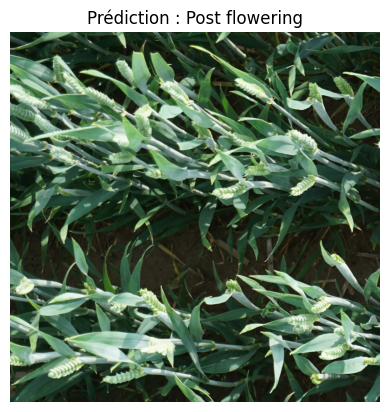

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Supprimer les lignes où le label est vide
df = df[df['developement_stage'].notna()]

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    #rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0004), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)

model.save("/content/drive/MyDrive/dataextractionfinal/model_resnet50.h5")


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 300s 8s/step - accuracy: 0.4005 - loss: 1.3553 - val_accuracy: 0.2971 - val_loss: 1.5940 - learning_rate: 4.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 279s 8s/step - accuracy: 0.5518 - loss: 0.9654 - val_accuracy: 0.4312 - val_loss: 1.9457 - learning_rate: 4.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 283s 8s/step - accuracy: 0.6351 - loss: 0.7615 - val_accuracy: 0.4891 - val_loss: 1.0046 - learning_rate: 4.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 316s 9s/step - accuracy: 0.6787 - loss: 0.7055 - val_accuracy: 0.4275 - val_loss: 1.8919 - learning_rate: 4.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 283s 8s/step - accuracy: 0.7195 - loss: 0.6302 - val_accuracy: 0.1957 - val_loss: 4.3407 - learning_rate: 4.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 283s 8s/step - accuracy: 0.7396 - loss: 0.6096 - val_accuracy: 0.5000 - val_loss: 1.7474 - learning_rate: 4.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 283s 8s/step - accuracy: 0.7818 

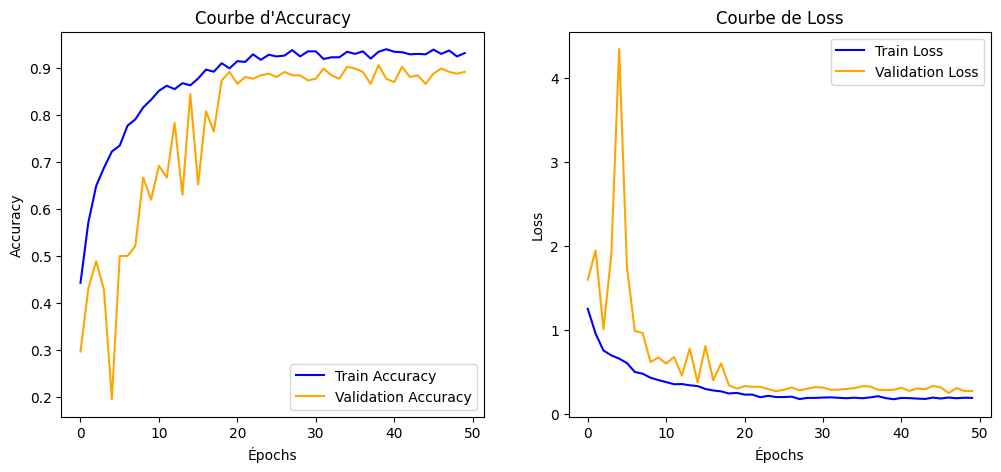

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


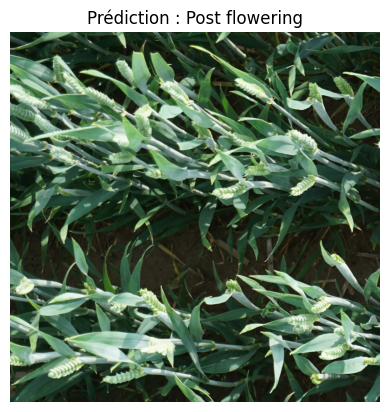

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Supprimer les lignes où le label est vide
df = df[df['developement_stage'].notna()]

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0004), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)

model.save("/content/drive/MyDrive/dataextractionfinal/model_resnet50.h5")


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 935ms/step - accuracy: 0.4004 - loss: 1.3593 - val_accuracy: 0.5036 - val_loss: 1.0444 - learning_rate: 4.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.5880 - loss: 0.8651 - val_accuracy: 0.6594 - val_loss: 0.8279 - learning_rate: 4.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 447ms/step - accuracy: 0.6575 - loss: 0.7352 - val_accuracy: 0.6739 - val_loss: 0.7414 - learning_rate: 4.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 438ms/step - accuracy: 0.7341 - loss: 0.6336 - val_accuracy: 0.5254 - val_loss: 0.9975 - learning_rate: 4.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 446ms/step - accuracy: 0.7741 - loss: 0.5426 - val_accuracy: 0.5036 - val_loss: 1.2143 - learning_rate: 4.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 436ms/step - accuracy: 0.7603 - loss: 0.5458 - val_accuracy: 0.2754 - val_loss: 18.7775 - learning_rate: 4.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - ac

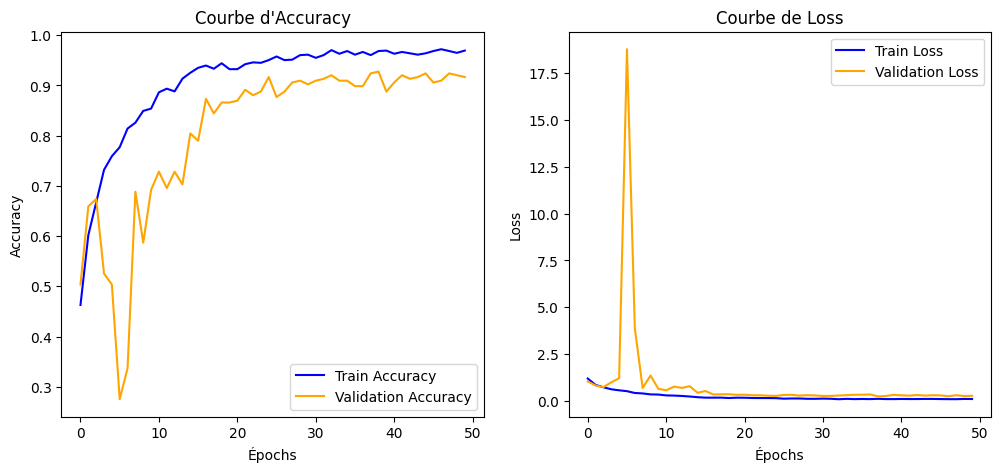

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


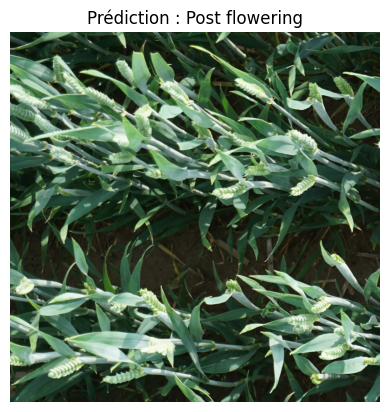

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Supprimer les lignes où le label est vide
df = df[df['developement_stage'].notna()]

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=10,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0004), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)

model.save("/content/drive/MyDrive/dataextractionfinal/model_resnet50.h5")


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 981ms/step - accuracy: 0.3792 - loss: 1.4062 - val_accuracy: 0.4928 - val_loss: 1.2013 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 450ms/step - accuracy: 0.5003 - loss: 1.0196 - val_accuracy: 0.3514 - val_loss: 1.2066 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step - accuracy: 0.6597 - loss: 0.7426 - val_accuracy: 0.3986 - val_loss: 1.1938 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - accuracy: 0.7172 - loss: 0.6558 - val_accuracy: 0.3913 - val_loss: 1.1977 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 516ms/step - accuracy: 0.7713 - loss: 0.5864 - val_accuracy: 0.4275 - val_loss: 1.2610 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 461ms/step - accuracy: 0.7662 - loss: 0.5132 - val_accuracy: 0.6304 - val_loss: 0.7944 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 521ms/step - acc

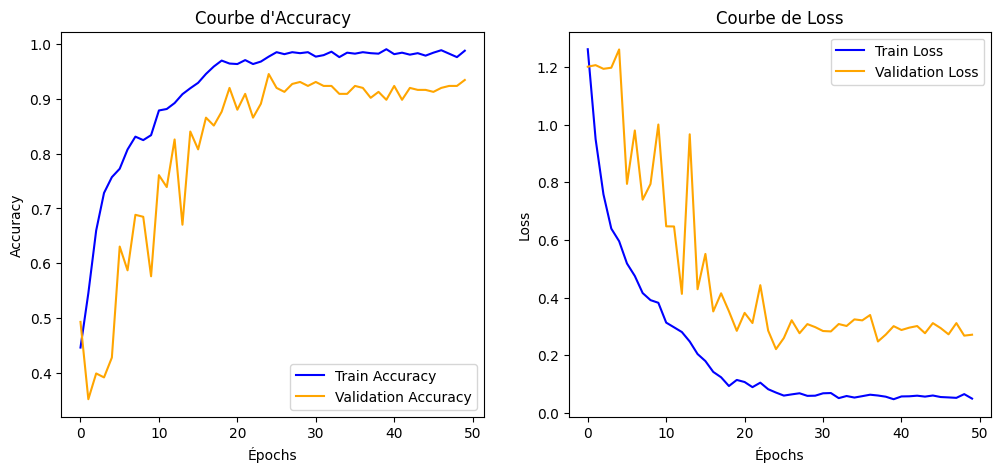

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


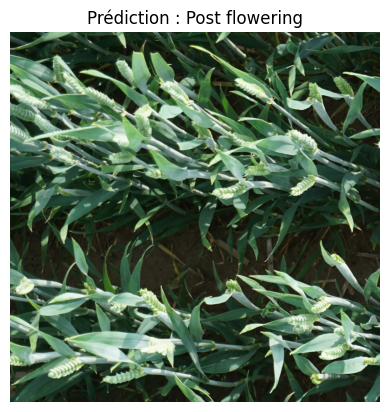

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Supprimer les lignes où le label est vide
df = df[df['developement_stage'].notna()]

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=10,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches de ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle (avec historique)
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)

model.save("/content/drive/MyDrive/dataextractionfinal/model_resnet50.h5")


Mounted at /content/drive
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4117 - loss: 1.3106 - val_accuracy: 0.8080 - val_loss: 0.6141 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 843ms/step - accuracy: 0.6632 - loss: 0.7349 - val_accuracy: 0.8551 - val_loss: 0.4664 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 888ms/step - accuracy: 0.7726 - loss: 0.5844 - val_accuracy: 0.8370 - val_loss: 0.4473 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 858ms/step - accuracy: 0.8179 - loss: 0.4677 - val_accuracy: 0.8696 - val_loss: 0.3389 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 833ms/step - accuracy: 0.8237 - loss: 0.4375 - val_accuracy: 0.8841 - val_loss: 0.3079 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 883ms/step - accuracy: 0.8758 - loss: 0.3528 - val_accuracy: 0.9094 - val_loss: 0.2455 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 809ms/step - accura

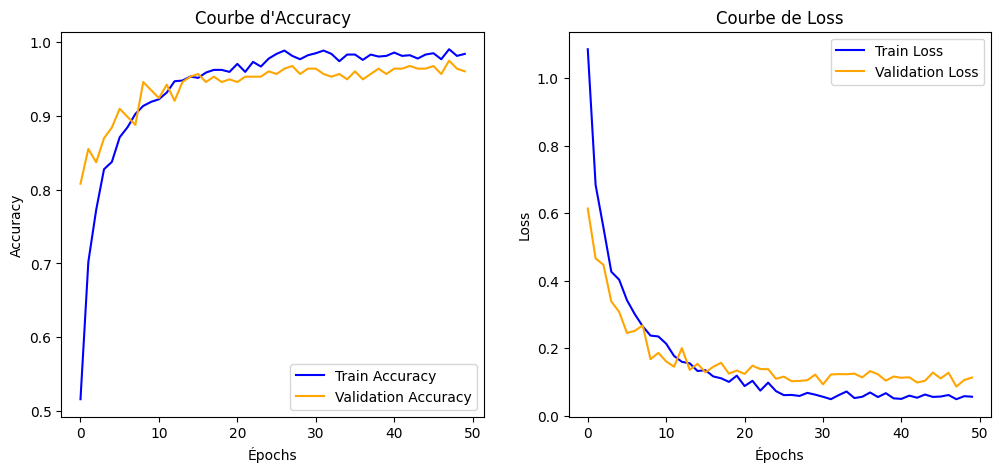

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


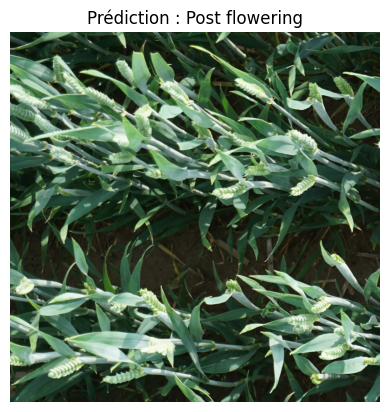

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Supprimer les lignes où le label est vide
df = df[df['developement_stage'].notna()]

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(299, 299)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=10,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger InceptionV3 pré-entraîné
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches d'InceptionV3
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None
    image = Image.open(image_path).convert("RGB").resize((299, 299))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()
    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder)

# Sauvegarder le modèle
model.save("/content/drive/MyDrive/dataextractionfinal/model_inceptionv3.h5")


In [ ]:
print(len(label_encoder.classes_))

4


Mounted at /content/drive
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4117 - loss: 1.3106 - val_accuracy: 0.8080 - val_loss: 0.6141 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 798ms/step - accuracy: 0.6632 - loss: 0.7349 - val_accuracy: 0.8551 - val_loss: 0.4664 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 801ms/step - accuracy: 0.7726 - loss: 0.5844 - val_accuracy: 0.8370 - val_loss: 0.4473 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 779ms/step - accuracy: 0.8179 - loss: 0.4677 - val_accuracy: 0.8696 - val_loss: 0.3389 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 791ms/step - accuracy: 0.8237 - loss: 0.4375 - val_accuracy: 0.8841 - val_loss: 0.3079 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 947ms/step - accuracy: 0.8758 - loss: 0.3528 - val_accuracy: 0.9094 - val_loss: 0.2455 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 793ms/step - accura

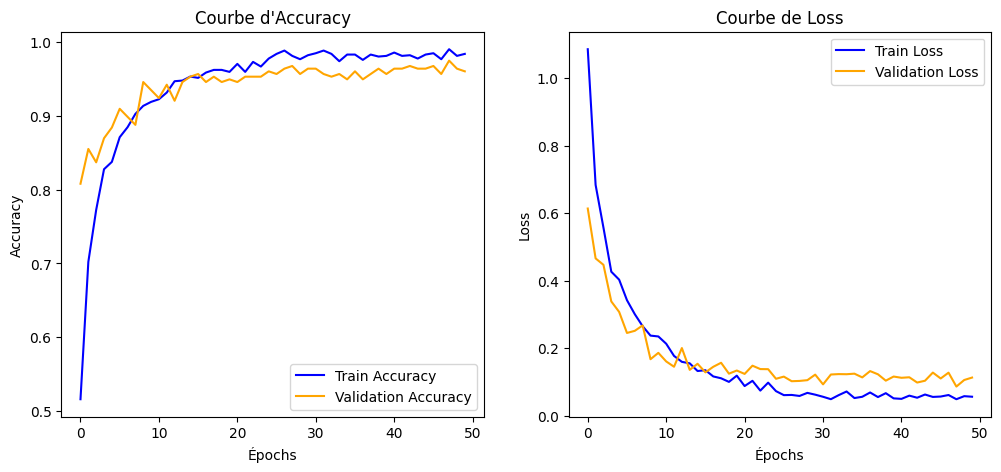

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


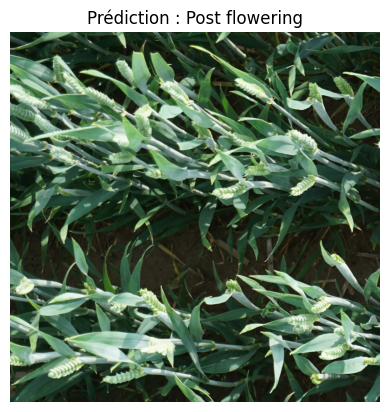

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import joblib  # Pour sauvegarder le LabelEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Fixer le seed pour garantir des résultats stables
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Monter Google Drive
drive.mount('/content/drive')

# Charger le fichier CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# Supprimer les lignes où le label est vide
df = df[df['developement_stage'].notna()]

# Vérifier les images existantes
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Sauvegarder le dataset filtré
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encoder les labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# 🔹 Sauvegarder le LabelEncoder
label_encoder_path = "/content/drive/MyDrive/dataextractionfinal/label_encoder.pkl"
joblib.dump(label_encoder, label_encoder_path)

# Fonction pour extraire les caractéristiques des boîtes
def extract_box_features(boxes_string):
    if boxes_string == 'no_box':
        return []
    try:
        return [list(map(int, box.split())) for box in boxes_string.split(';') if len(box.split()) == 4]
    except ValueError:
        return []

df_existing['box_features'] = df_existing['BoxesString'].apply(extract_box_features)

# Équilibrage des classes
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Charger les images et labels
def load_and_preprocess_images(df, image_dir, target_size=(299, 299)):
    images, labels = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size)
            image = np.array(image) / 255.0
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Data Augmentation (avec seed)
datagen = ImageDataGenerator(
    rotation_range=10,
    fill_mode="nearest",
    validation_split=0.2
)

# Charger InceptionV3 pré-entraîné
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Construire le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Débloquer les 10 dernières couches d'InceptionV3
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

# Fonction pour afficher les courbes d'entraînement
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

# Affichage des courbes
plot_training_curves(history)

# Fonction de prédiction
def predict_image(image_path, model, label_encoder_path):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None

    # 🔹 Recharger le LabelEncoder
    label_encoder = joblib.load(label_encoder_path)

    image = Image.open(image_path).convert("RGB").resize((299, 299))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()

    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder_path)

# 🔹 Sauvegarder le modèle
model.save("/content/drive/MyDrive/dataextractionfinal/model_inceptionv3.h5")


**Growth Stage Prediction**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4117 - loss: 1.3106 - val_accuracy: 0.8080 - val_loss: 0.6141 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 780ms/step - accuracy: 0.6632 - loss: 0.7349 - val_accuracy: 0.8551 - val_loss: 0.4664 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 840ms/step - accuracy: 0.7726 - loss: 0.5844 - val_accuracy: 0.8370 - val_loss: 0.4473 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 783ms/step - accuracy: 0.8179 - loss: 0.4677 - val_accuracy: 0.8696 - val_loss: 0.3389 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 781ms/step - accuracy: 0.8237 - loss: 0.4375 - val_accuracy: 0.8841 - val_loss: 0.3079 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 779ms/step - accuracy: 0.8758 - loss: 0.3528 - val_accuracy: 0.9094 - val_loss: 0.2455 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 795ms/step - accura

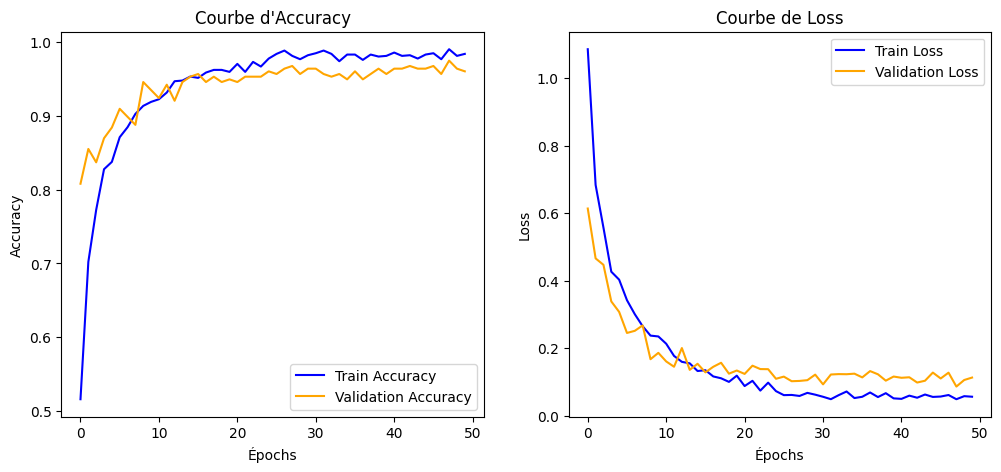

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


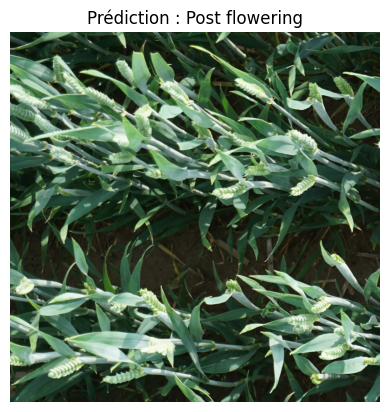

In [ ]:
#library imports
import os
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import joblib  # Pour sauvegarder le LabelEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

#Set Random Seed for Reproducibility to ensure that the results are stable
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

#Mount Google Drive
drive.mount('/content/drive')

# Load and Filter CSV
csv_file = "/content/drive/MyDrive/dataextractionfinal/train_filtered.csv"
df = pd.read_csv(csv_file, sep=';')

# removes rows with missing labels in the developement_stage column
df = df[df['developement_stage'].notna()]

# Check Existing Images and i ensures only image files that physically exist in the folder are kept in the DataFrame.
image_dir = "/content/drive/MyDrive/dataextractionfinal/images/"
existing_images = set(os.listdir(image_dir))
df['image_name'] = df['image_name'].str.strip()
df_existing = df[df['image_name'].isin(existing_images)].reset_index(drop=True)

# Saves the cleaned dataset to a new CSV file.
final_csv_path = "/content/drive/MyDrive/dataextractionfinal/train_final.csv"
df_existing.to_csv(final_csv_path, sep=';', index=False)

# Encode Labels
label_encoder = LabelEncoder()
df_existing['development_stage_encoded'] = label_encoder.fit_transform(df_existing['developement_stage'])

# 🔹 Save Label Encoder to used later for prediction
label_encoder_path = "/content/drive/MyDrive/dataextractionfinal/label_encoder.pkl"
with open(label_encoder_path, "wb") as f:
    joblib.dump(label_encoder, f)

# Balance Classes by Oversampling
class_counts = df_existing['development_stage_encoded'].value_counts()
max_count = class_counts.max()
df_balanced = df_existing.copy()

for class_id, count in class_counts.items():
    if count < max_count:
        df_to_add = df_existing[df_existing['development_stage_encoded'] == class_id]
        df_balanced = pd.concat([df_balanced, df_to_add.sample(max_count - count, replace=True, random_state=SEED)], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Load and Preprocess Images
def load_and_preprocess_images(df, image_dir, target_size=(299, 299)):
    images, labels = [], [
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        try:
            image = Image.open(image_path).convert("RGB").resize(target_size) #resized all images to the target size
            image = np.array(image) / 255.0 #normalizes them to the range [0, 1],
            images.append(img_to_array(image))
            labels.append(row['development_stage_encoded'])
        except Exception as e:
            print(f"⚠️ Erreur avec l'image {image_path}: {e}")
    return np.array(images), np.array(labels)
# Calls the function to load and preprocess images and their corresponding labels
images, labels = load_and_preprocess_images(df_balanced, image_dir)

# Adds data augmentation and creates an 80/20 training-validation split.
datagen = ImageDataGenerator(
    rotation_range=10,
    fill_mode="nearest",
    validation_split=0.2
)

#Load Pre-trained InceptionV3
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
# Add Custom Layers
#global pooling
#two dense layers with ReLU
#dropout for regularization
# a final softmax layer for multi-class output
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#Constructs the final model and freezes all but the last 10 layers of InceptionV3. Then compiles the model.
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#Set Learning Rate Scheduler
#Reduces the learning rate automatically if validation loss doesn’t improve for 3 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
#Train the Model for 50 epochs using augmented data with batch sizes 32
history = model.fit(
    datagen.flow(images, labels, batch_size=32, subset='training'),
    validation_data=datagen.flow(images, labels, batch_size=16, subset='validation'),
    epochs=50,
    callbacks=[reduce_lr]
)

#  function to plot accuracy and loss for training and validation over time.
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.title("Courbe d'Accuracy")
    plt.legend()

    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.legend()

    plt.show()

plot_training_curves(history)

#Prediction Function
def predict_image(image_path, model, label_encoder_path):
    if not os.path.exists(image_path):
        print("⚠️ Image introuvable !")
        return None

    # 🔹 Recharger correctement le LabelEncoder
    with open(label_encoder_path, "rb") as f:
        label_encoder = joblib.load(f)

    image = Image.open(image_path).convert("RGB").resize((299, 299))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Prédiction : {predicted_class[0]}")
    plt.show()

    return predicted_class[0]

# Exemple de prédiction
image_name = "0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8bdb633bada3023c085.png"
image_path = os.path.join(image_dir, image_name)
predict_image(image_path, model, label_encoder_path)

# Save Trained Model
model.save("/content/drive/MyDrive/dataextractionfinal/model_inceptionv3.h5")
